In [12]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import numpy as np

pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns

race_id = 5392
driver_index = 29
lap_time_cutoff = 17.5

In [13]:
# Find race name and location

url = 'https://cf.nascar.com/cacher/2024/race_list_basic.json'
json = requests.get(url).json()
race = pd.json_normalize(json['series_1'])
race = race[['race_id', 'track_name', 'race_name']].set_index('race_id')
race = race.loc[race_id]
location = race.values[0]
name = race.values[1]
race = name + ' @ ' + location

#print(race)

print(race)

Food City 500 @ Bristol Motor Speedway


In [14]:
# Find driver info by index number (ex: Suarez is 17)
url = 'https://cf.nascar.com/cacher/2024/1/5392/lap-times.json'
json = requests.get(url).json()
driver = pd.json_normalize(json['laps'])

print(driver[['Number','FullName','Manufacturer','NASCARDriverID']])

   Number              FullName Manufacturer  NASCARDriverID
0      11          Denny Hamlin          Tyt            1361
1      19      Martin Truex Jr.          Tyt            3368
2       6       Brad Keselowski          Frd            1816
3      48           Alex Bowman          Chv            4045
4       5           Kyle Larson          Chv            4030
5      42  John Hunter Nemechek          Tyt            4092
6      17        Chris Buescher          Frd            3989
7       9         Chase Elliott          Chv            4062
8      54              Ty Gibbs          Tyt            4368
9      20      Christopher Bell          Tyt            4153
10     34      Michael McDowell          Frd            3832
11      4          Josh Berry #          Frd            4123
12     14         Chase Briscoe          Frd            4228
13     41           Ryan Preece          Frd            4070
14      1         Ross Chastain          Chv            4001
15     12           Ryan

In [15]:
# Find driver name by index
# race is Bristol Food City 500


url = f'https://cf.nascar.com/cacher/2024/1/{race_id}/lap-times.json'
json = requests.get(url).json()
driver = pd.json_normalize(json['laps'][driver_index])
driver = driver['FullName'].iloc[0]


print(driver)
print(race)


Tyler Reddick
Food City 500 @ Bristol Motor Speedway


In [29]:
# driver laps

df = pd.json_normalize(json['laps'][driver_index]['Laps']).drop(0)

print('\n', driver, '\n')
print('\nTotal Average Lap Time: ', df['LapTime'].mean())
print('Total Average Lap Speed: ', df['LapSpeed'].astype(float).mean(), '\n')
print(df.head())


 Tyler Reddick 


Total Average Lap Time:  24.323242424242423
Total Average Lap Speed:  96.94607676767677 

   Lap  LapTime LapSpeed  RunningPos
1    1   16.797  114.235          24
2    2   16.014  119.820          22
3    3   16.432  116.772          23
4    4   16.040  119.626          22
5    5   16.106  119.136          21


In [28]:
# non-green lap times throw off average, check for slow lap times

print(df.head(), '\n')
print(df['LapTime'].head() > lap_time_cutoff)

   Lap  LapTime LapSpeed  RunningPos
1    1   16.797  114.235          24
2    2   16.014  119.820          22
3    3   16.432  116.772          23
4    4   16.040  119.626          22
5    5   16.106  119.136          21 

1    False
2    False
3    False
4    False
5    False
Name: LapTime, dtype: bool


In [18]:
# take out yellow flag laps by lap_time_cutoff
# post fixed averages

race_laps = df[df['LapTime'] < lap_time_cutoff]

print('\n', driver, '\n')
print('Min Lap: ', race_laps['LapTime'].min())
print('Ave Lap: ', race_laps['LapTime'].astype(float).mean())
print('Max Lap: ', race_laps['LapTime'].max(), '\n')
print('Averages:\n', race_laps[['LapTime','LapSpeed','RunningPos']].astype(float).mean())


 Tyler Reddick 

Min Lap:  16.014
Ave Lap:  16.98431884057971
Max Lap:  17.484 

Averages:
 LapTime        16.984319
LapSpeed      113.009278
RunningPos     32.423188
dtype: float64


In [27]:
# present cleaned data

print(race_laps.head(10))

    Lap  LapTime LapSpeed  RunningPos
1     1   16.797  114.235          24
2     2   16.014  119.820          22
3     3   16.432  116.772          23
4     4   16.040  119.626          22
5     5   16.106  119.136          21
6     6   16.152  118.796          21
7     7   16.371  117.207          21
8     8   16.462  116.559          21
9     9   16.160  118.738          20
10   10   16.731  114.685          20


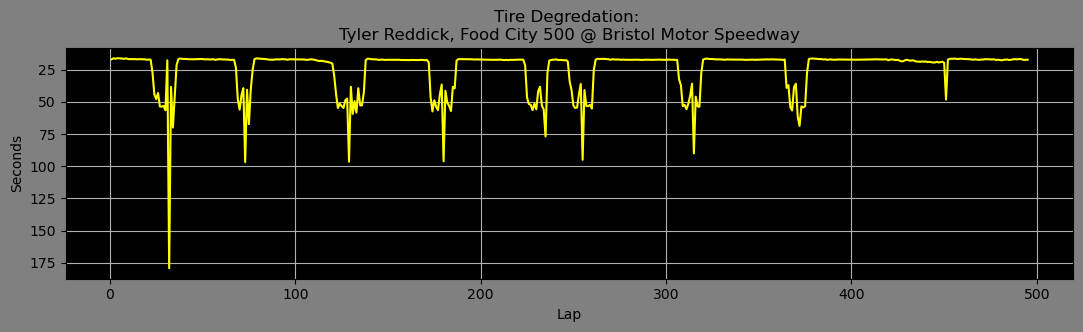

In [20]:
# tire degredation with all laps

laptime = df['LapTime']
lap = df['Lap']
title = 'Tire Degredation: \n' + driver + ', ' + race

fig, ax = plt.subplots(figsize=(13,3))
ax.plot(lap, laptime, color='yellow')
ax.invert_yaxis()
ax.set_xlabel('Lap')
ax.set_ylabel('Seconds')
ax.set_title(title)
ax.set_facecolor('black')
fig.set_facecolor('grey')
ax.grid()
plt.show()

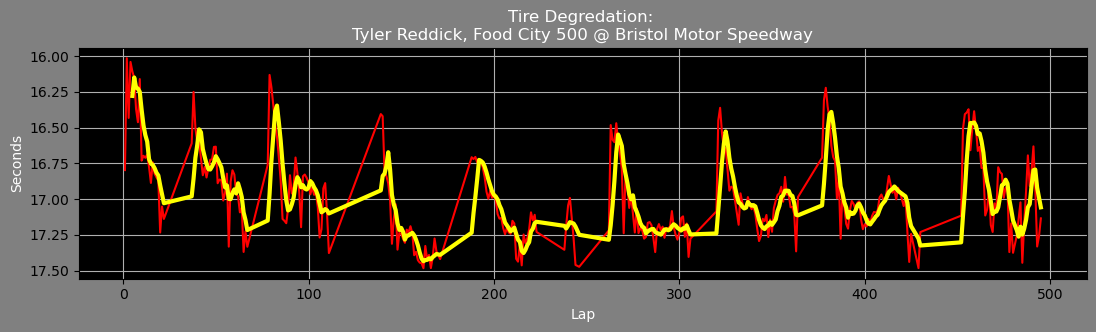

In [21]:
# plot tire degredation w/cleaned data
# set laptime, lap for y, x
laptime = race_laps['LapTime']
lap = race_laps['Lap']


#create simple moving average
moving_average = laptime.rolling(5).mean()

fig, ax = plt.subplots(figsize=(13,3))
ax.plot(lap, laptime, color='red') 
ax.plot(lap, moving_average, color='yellow', linewidth=3)
ax.invert_yaxis()
ax.set_xlabel('Lap', color='white')
ax.set_ylabel('Seconds', color='white')
ax.set_title(title, color='white')
ax.set_facecolor('black')
fig.set_facecolor('grey')
ax.grid()
plt.savefig(f'Tire_Degredation_{driver}_{race}.png', bbox_inches = 'tight')
plt.show()

In [26]:
start_pos = df['RunningPos'].head(1)
start_pos = start_pos[1]
end_pos = df['RunningPos'].tail(1).to_numpy()
end_pos = end_pos[0]

print(driver + ', ' + race)
print('Min Lap: ', race_laps['LapTime'].min())
print('Max Lap: ', race_laps['LapTime'].max(), '\n')
print(f'Started: P-{start_pos} \nEnded: P-{end_pos}')

Tyler Reddick, Food City 500 @ Bristol Motor Speedway
Min Lap:  16.014
Max Lap:  17.484 

Started: P-24 
Ended: P-30
